# Notebook to make Fig. 4: compare posteriors with and without time of coalescence and sky position

In [0]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
import lal
import importlib

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D
from textwrap import wrap

import seaborn as sns
cp = sns.color_palette('colorblind')
cp2 = sns.color_palette('pastel')
colormaps = [cp, cp2]

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("",['#CC79A7', '#D55E00', '#E69F00', '#0072B2'])

from helper_functions import *

import sys
sys.path.append('../utils')
import reconstructwf as rwf

style.use('plotting.mplstyle')

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


### Load samples

In [1]:
data_dir = '/Users/smiller/Documents/gw190521-timedomain-release/data_simonas_laptop/' 

template = data_dir+'063023_gw190521_{0}_NRSur7dq4_dec8_flow11_fref11_{1}_TstartTend{2}.dat'

paths = {
    'full fixed t and skypos':template.format('full', '0M', ''),
    'full vary t and skypos':template.format('full', '0M', '_VaryTAndSkyPos'),
    'm10M fixed t and skypos':template.format('rd', 'm10M', ''),
    'm10M vary t and skypos':template.format('rd', 'm10M', '_VaryTAndSkyPos'),
    'm40M fixed t and skypos':template.format('rd', 'm40M', ''),
    'm40M vary t and skypos':template.format('rd', 'm40M', '_VaryTAndSkyPos')
}

td_samples = {k: np.genfromtxt(p, names=True, dtype=float) for k, p in paths.items()}

In [2]:
# Format into way to plot

posteriors_to_plot = {}

for key, samples in td_samples.items(): 
    
    mtotal = samples['mtotal']
    q = samples['q']
    
    m1, m2 = m1m2_from_mtotq(mtotal,q)
    
    chieff = chi_effective(m1, samples['chi1'], samples['tilt1'],
                          m2, samples['chi2'], samples['tilt2'])
    chip = chi_precessing(m1, samples['chi1'], samples['tilt1'],
                          m2, samples['chi2'], samples['tilt2'])

    posteriors_to_plot[key] = {
        'mtotal':mtotal,
        'q':q,
        'chieff':chieff,
        'chip':chip
    }

### Make figure

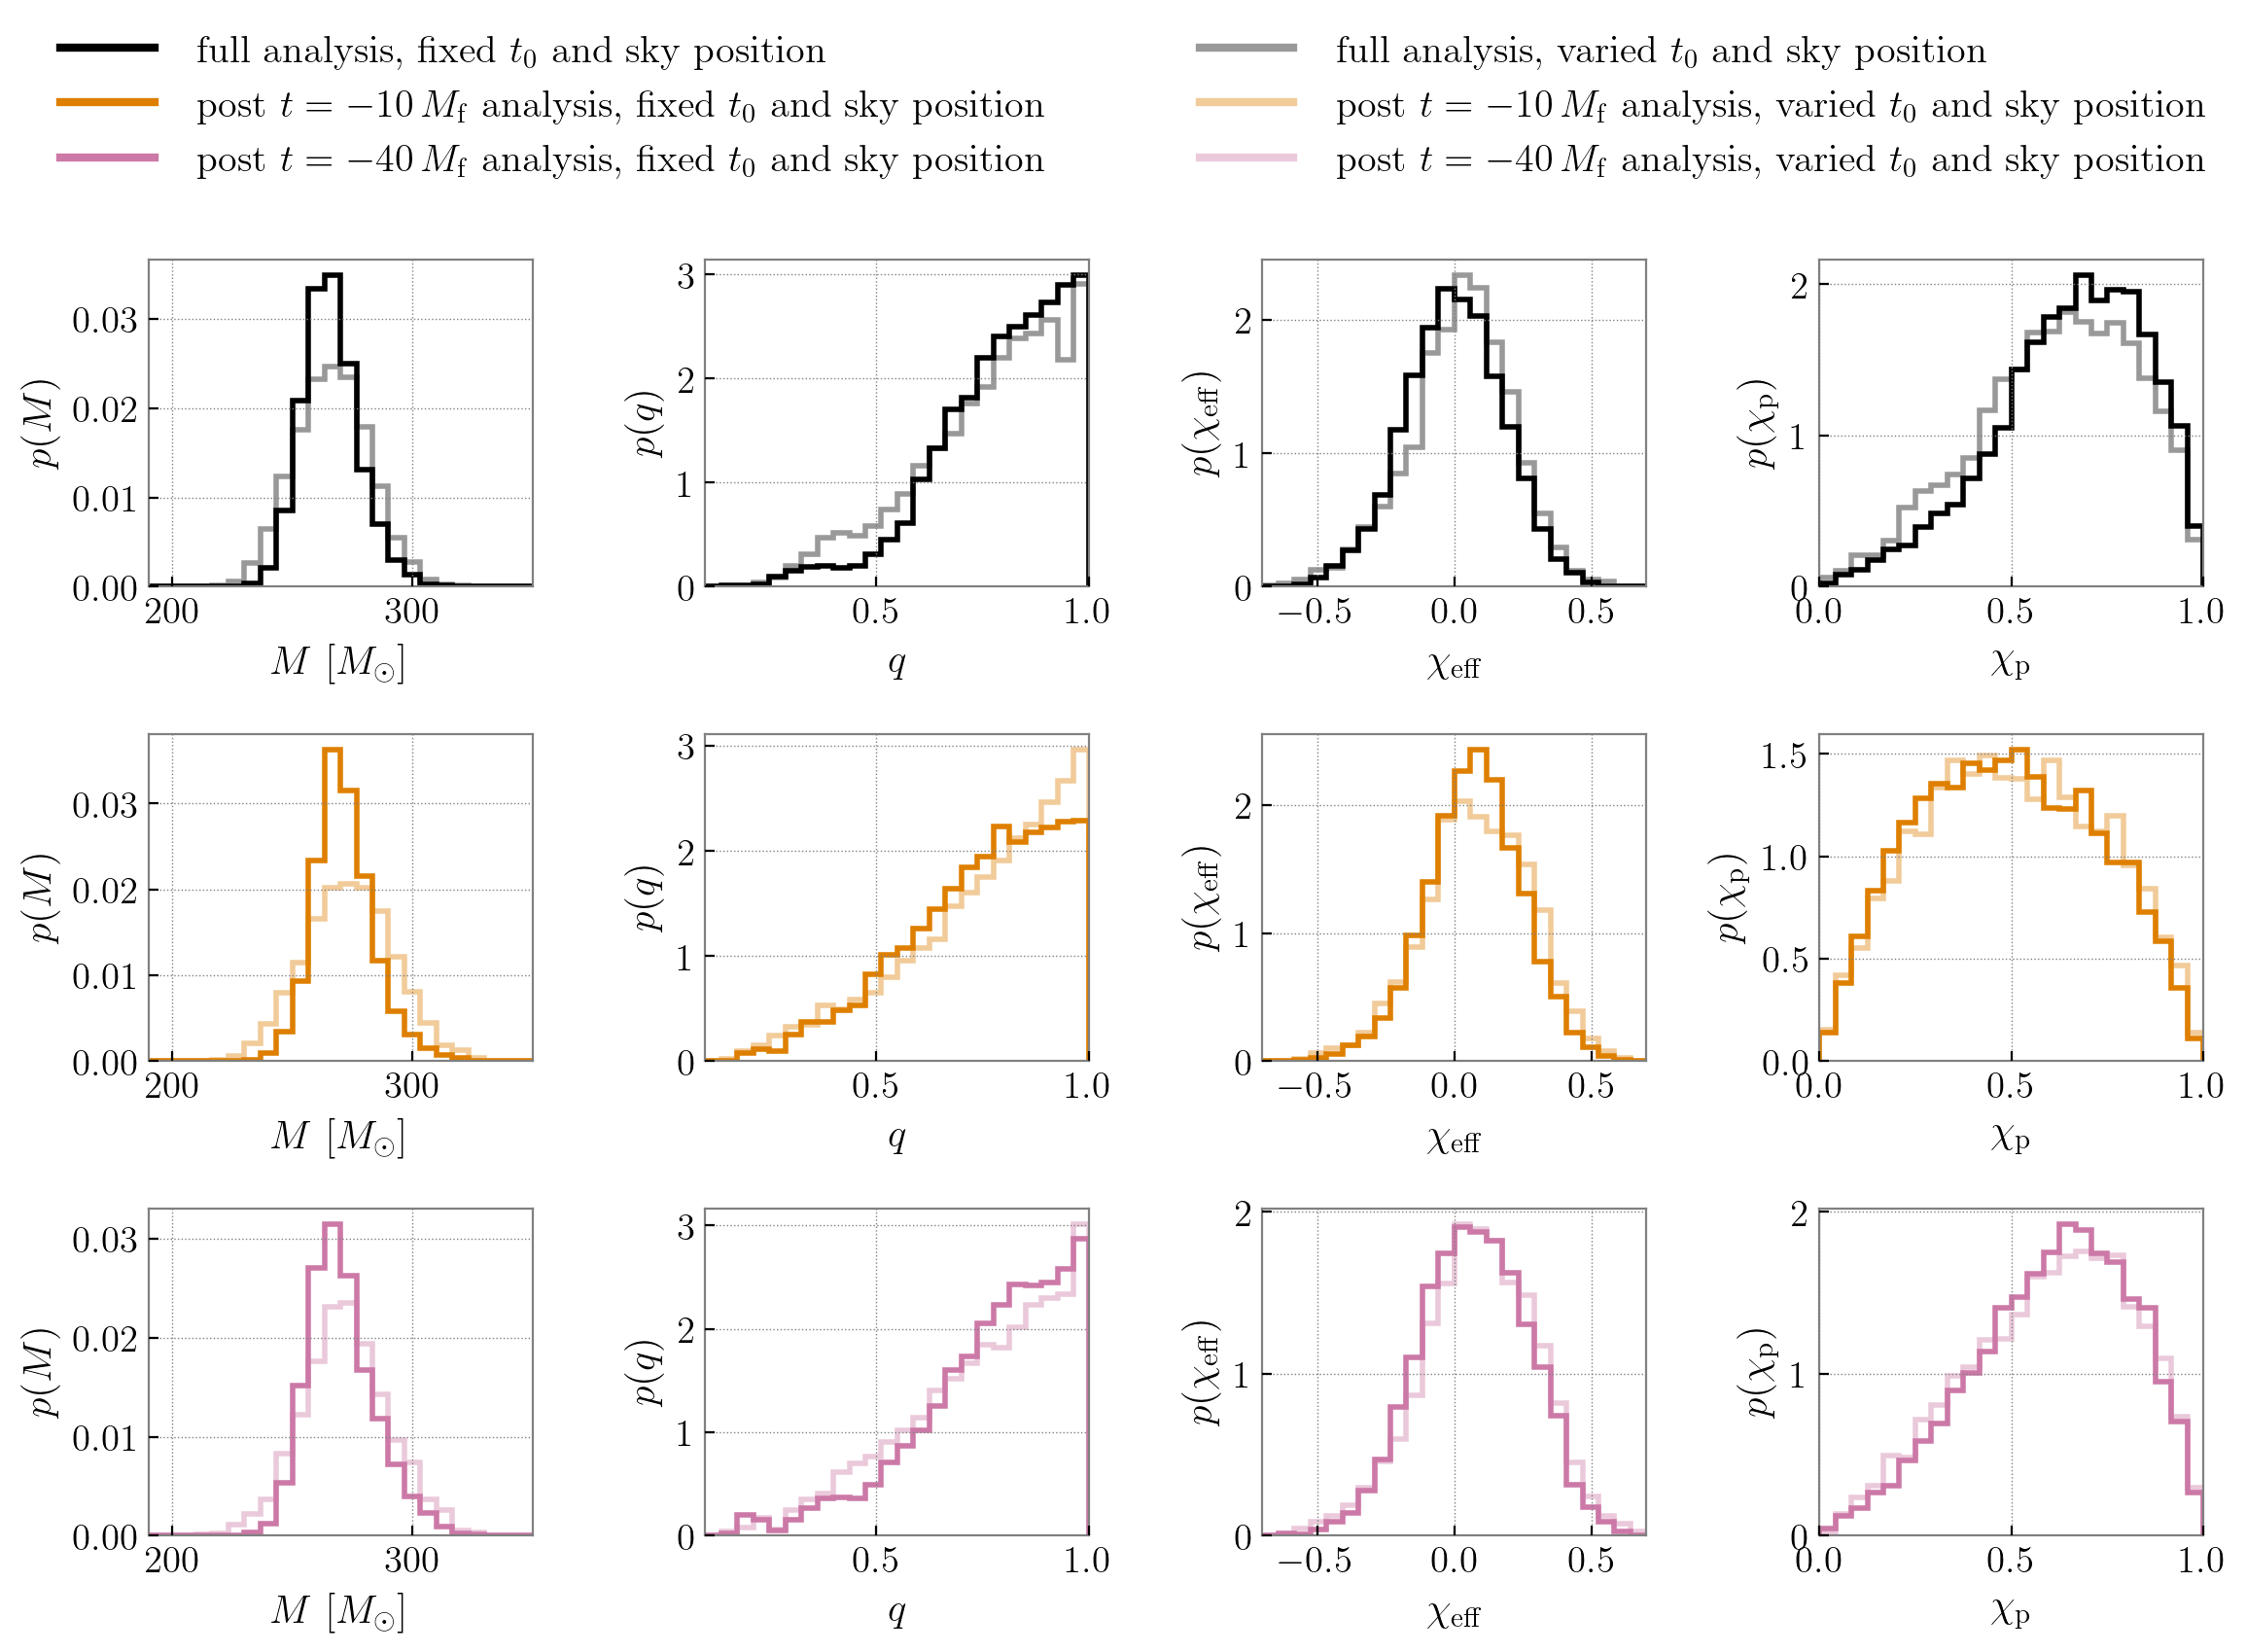

In [3]:
# Waveform parameters: 
params = ['mtotal', 'q', 'chieff', 'chip']

# Runs to plot
runs = ['full', 'm10M', 'm40M']
modes = ['fixed t and skypos', 'vary t and skypos']

# Labels 
labels_dict = {
    'mtotal':r'M',
    'q':r'q',
    'chieff':r'\chi_\mathrm{eff}',
    'chip':r'\chi_\mathrm{p}'
}

# Bounds 
bounds_dict = {
    'mtotal':[190,350],
    'q':[0.1,1],
    'chieff':[-0.7,0.7],
    'chip':[0,1]
}

colors = ['k',  cmap(0.5), cmap(0.001)]
alphas = [1, 0.4]

# Make figure 
fig, axes = plt.subplots(len(runs), len(params), figsize=(15/1.1, 25*len(runs)/8/1.1))

# Cycle through runs
for i, run in enumerate(runs): 
    
    # Cycle through parameters
    for j, param in enumerate(params): 
        
        for k, mode in enumerate(modes): 
            
            key = run+' '+mode
            posterior = posteriors_to_plot[key][param]
        
            nbins = 25
            bins = np.linspace(*bounds_dict[param], nbins)
            #c = colormaps[k]
            c = colors[i]
            a = alphas[k]
            axes[i,j].hist(posterior, density=True, histtype='step', 
                                           bins=bins, lw=2, label=mode, color=c, alpha=a)
            
        label = labels_dict[param]
        if param=='mtotal':
            axes[i,j].set_xlabel(r'${0}~[M_\odot]$'.format(label), fontsize=15)
        else:
            axes[i,j].set_xlabel(r'${0}$'.format(label), fontsize=15)
        axes[i,j].set_ylabel(r'$p({0})$'.format(label), fontsize=15)
        axes[i,j].set_xlim(*bounds_dict[param])
        
        
# Legend
handles = [
    Line2D([], [], color=colors[0], alpha=alphas[0], 
           label='full analysis, fixed $t_0$ and sky position'),
    Line2D([], [], color=colors[1], alpha=alphas[0], 
           label='post $t = -10\,M_\mathrm{f}$ analysis, fixed $t_0$ and sky position'),
    Line2D([], [], color=colors[2], alpha=alphas[0], 
           label='post $t = -40\,M_\mathrm{f}$ analysis, fixed $t_0$ and sky position'), 
    Line2D([], [], color=colors[0], alpha=alphas[1], 
           label='full analysis, varied $t_0$ and sky position'),
    Line2D([], [], color=colors[1], alpha=alphas[1], 
           label='post $t = -10\,M_\mathrm{f}$ analysis, varied $t_0$ and sky position'),
    Line2D([], [], color=colors[2], alpha=alphas[1], 
           label='post $t = -40\,M_\mathrm{f}$ analysis, varied $t_0$ and sky position'),
]
leg = axes[0][0].legend(
    handles=handles, 
    bbox_to_anchor=(-0.3, 1.2, 5.7, .102), loc='lower left', ncols=2, 
    mode="expand", borderaxespad=0., frameon=False, fontsize=14.5, handlelength=3
)
for i, h in enumerate(handles):
    leg.get_lines()[i].set_linewidth(3)
        
plt.subplots_adjust(hspace=0.45, wspace=0.45)
plt.savefig('figure_04.pdf', bbox_inches='tight')
plt.show()